In [1]:
import xpress as xp
import pandas as pd
import numpy as np

import re

In [2]:
# Data input
demand = pd.read_excel('Demand_data1.xlsx')
#chargepoints = pd.read_excel('Charging_points.xlsx')
#potentialcharge = pd.read_excel('Potential_charging_points.xlsx')
#interest = pd.read_excel('Interest _points.xlsx')

In [3]:
# Create a problem
prob = xp.problem(name='pro')

In [4]:
# Defining the index sets
#number_of_periods = 4
number_of_grids = 434
type_of_chargers = 3

number_of_chargers = 78
number_of_pchargers = 325

#Periods = range(number_of_years)
Grids = range(number_of_grids)
Chargers = range(type_of_chargers)


In [5]:
## Define variables 
# calculate the individual grid supply 
isupply = [xp.var (name="isupply_{0}".format(g), lb=0) for g in Grids]
# final supply amount given the assumption about power sharing between grids
tsupply = [xp.var (name="tsupply_{0}".format(g), lb=0) for g in Grids]

# demand-supply difference 
diff = [xp.var (name="diff_{0}".format(g), lb=-50000) for g in Grids]

# unmet demand:  'diff' if diff > 0; 0 if diff <= 0
undemand = [xp.var (name="undemand_{0}".format(g), lb=0) for g in Grids]

#budget 
budget = xp.var('budget', lb=0)

prob.addVariable(isupply, tsupply, diff , undemand , budget)

In [6]:
## Adding Stations and points 


#total new points 
newpoint = [xp.var (name="newpoint_{0}".format(g), vartype=xp.integer, lb=0) for g in Grids]
#number of types of new points

newpointty = {(g, c): xp.var(vartype=xp.integer, name='newpointty{0}_{1}'.format(g, c))
              for g in Grids for c in Chargers}

#stations = number of stations built at each charging point (max = 20)
newstations = [xp.var (name="newstations_{0}".format(g),vartype=xp.integer) for g in Grids]
#variable for each type of station 

newstationsty = {(g, c): xp.var(vartype=xp.integer, name='newstationsty{0}_{1}'.format(g, c))
                for g in Grids for c in Chargers}

#new_supply from the newly built stations 
newpower = [xp.var (name="newpower_{0}".format(g)) for g in Grids]

#for each pre-existing charging station you can add upto X new stations 
addstations = [xp.var (name="addstations{0}".format(g), vartype=xp.integer) for g in Grids]

addstationsty = {(g, c): xp.var(vartype=xp.integer, name='addstationsty{0}_{1}'.format(g, c))
                for g in Grids for c in Chargers}

# additional supply for the additional stations: 
addpower = [xp.var (name="addpower{0}".format(g)) for g in Grids]


prob.addVariable(newpoint, newpointty,
                 newstations, newstationsty,
                 newpower, 
                 addstations, addstationsty,
                 addpower)


In [7]:
#Problem Parameters
charger_names = ['Slow', 'Fast', 'Rapid']
chargerpower = [2750, 4600, 40250]

chargerprice = [12500, 14000, 52000] ## for slow, fast, rapid chargers
concost = 3000 ## infrastructure construction cost

# demand matrix for each grid -- year 4 demand
targetdemand = demand['Demand_3']
targetdemand = targetdemand.to_numpy()

#max stations per new point 
maxchargestation = 4
#mas stations added to pre-existing point 
add_lim = 2


#Currentchargers = chargepoints[['Type','grid_number']]
# Current chargers availability:
currentchargers = demand[['Number_of Slow_Charging_Points','Number_of_Fast_Charging_Points','Number_of Rapid_Charging_Points']]
currentchargers = currentchargers.to_numpy() ## convert to array


# Potential Charging points per grid g: 
ppoint_per_grid = demand['Number_of_Potential_Locations']
ppoint_per_grid = ppoint_per_grid.to_numpy()

#Number of pre-existing charging points per grid 
init_points_pgrid = demand['Number_of_Charging_Points']
init_points_pgrid = init_points_pgrid.to_numpy()

#Number of interest points per grid 
interest_points_grid = demand['Number_of_PoI']
interest_points_grid = interest_points_grid.to_numpy()

In [8]:
## current expenditure
cbudget = 0

for g in Grids:
    for c in Chargers:
        #current expenditure = cost of building all chargers already in all grids 
        cbudget += chargerprice[c]*currentchargers[g,c]
    #add the construction cost for each charger that exists
    cbudget += number_of_chargers*concost
    
#print(cbudget) 

## current expenditure
cbudget = 0

for g in Grids:
    for c in Chargers:
        #current expenditure = cost of building all chargers already in all grids 
        cbudget += chargerprice[c]*currentchargers[g,c]
    #add the construction cost for each charger that exists
    cbudget += init_points_pgrid[g]*concost
    
#print(cbudget) 

In [9]:
## 'neighbours': matrix of neighbors and itself [343*9, 0 will be filled if num_of_share <9]
## each grid and its neighbours can support charging
neighbors = demand['NEIGHBORS']

neighbours = np.zeros((number_of_grids,9))
for g in Grids:
    nums = neighbors.iloc[g]
    num = re.findall(r'\d+', nums)
    num = list(map(int, num))
    num = np.append(arr = np.array([g+1]), values = num, axis= 0) ## add itself to the start
    #num.append(g+1) ## add itself
    while len(num)<9: ## fill in zeroes for grids with less than 9 neighbors
        #num.append(0)
        num = np.append( arr = np.array([0]), values = num, axis=0)
        
    neighbours[g,]=num
    
neighbours = neighbours.astype(int) ## convert to an integer array

In [10]:
## Grid Power Sharing
## Constraint 1: Filter the neighbours for each grid: Remove the neighbours with no demand 

for g in Grids:
    for i in range(9):
            ne = neighbours[g,i]
            if ne >0:
            ## remove those grids with no demand
                if (targetdemand[ne-1]==0) : 
                    neighbours[ne-1,][neighbours[ne-1,]== (g+1)] = 0 
                    neighbours[g,i] = 0 

In [11]:
## Number of grids that each grid will share its power to 
num_of_share = (neighbours != 0).sum(1)

In [12]:
#current power supply from each grid 
cpower = np.zeros(number_of_grids)
for g in Grids:
    for c in Chargers:
        cpower[g] = cpower[g] + chargerpower[c]*currentchargers[g,c]


In [13]:
## potential charging points

#new points built per grid limited by the number of potential points per grid

prob.addConstraint(newpoint[g] <= ppoint_per_grid[g] for g in Grids)

prob.addConstraint(newpoint[g] == xp.Sum( newpointty[g,c] for c in Chargers) 
                   for g in Grids)

#station type must match point type. number of stations per point is limited
prob.addConstraint(newstationsty[g,c] <= maxchargestation*newpointty[g,c]
                   for c in Chargers for g in Grids)

#!! add a lower bound for the number of stations for each built new point
prob.addConstraint(newpointty[g,c] <= newstationsty[g,c]
                   for c in Chargers for g in Grids)


#Power from the new charging points, calculated as the sum of power from each station
prob.addConstraint(newpower[g] == xp.Sum( newstationsty[g,c]*chargerpower[c] for c in Chargers)
                   for g in Grids)


In [14]:
## additional charging stations 
     

prob.addConstraint(addstationsty[g,c] <= add_lim*currentchargers[g,c]
                   for g in Grids for c in Chargers)
    
prob.addConstraint(newstations[g] == xp.Sum( newstationsty[g,c] for c in Chargers )
                   for g in Grids) 
        
        
#total additional stations is the sum of all the additional stations 
prob.addConstraint(addstations[g] == xp.Sum( addstationsty[g,c] for c in Chargers )
                   for g in Grids) 

#additional power = sum power from each additional station 
prob.addConstraint(addpower[g] == xp.Sum( addstationsty[g,c]*chargerpower[c] for c in Chargers )
                   for g in Grids) 


#ASSUMPTION : pre-existing charging point only has one station 

In [15]:
## interest points

prob.addConstraint(xp.Sum(init_points_pgrid[ne-1]+addstations[ne-1]+newstations[ne-1] for ne in neighbours[g,] if (ne >0) and (num_of_share[ne-1]>0) ) >= interest_points_grid[g]
                   for g in Grids if num_of_share[g] >0)



In [16]:
#individual supply from each grid : 
# cpower = current power (from pre-existing stations)
# newpower = power from new stations 
# addpower = power from added stations 
prob.addConstraint( isupply[g] == cpower[g] + newpower[g] + addpower[g]
                   for g in Grids)

# the supply recieved by grid g by all its neighbours 
prob.addConstraint( tsupply[g] == xp.Sum(isupply[ne-1]/num_of_share[ne-1] 
                                         for ne in neighbours[g,] if (ne >0) and (num_of_share[ne-1]>0))
                    for g in Grids)


In [17]:
## City Centre: G215 + neighbouring grids
## sensitivity analysis: change the bound, 

## Special requirement: 1. The number of charging stations must not exceed some bound
## 2. The total number of charging stations must not exceed ... (after Fatima's model)

citycentre = [184,185,186,198,199,200,201,213,214,215,229]

prob.addConstraint(xp.Sum(init_points_pgrid[cg-1]+addstations[cg-1]+newstations[cg-1] for cg in citycentre) <= 30)

csb = 30

In [18]:
# Deficit = difference between the demand and supply of grid g 
prob.addConstraint( diff[g] == targetdemand[g] - tsupply[g] for g in Grids)



In [19]:
## Diversification
## Proportion of rapid chargers must not exceed 20%
## xp.Sum(currentchargers[g,2] for g in Grids) = 13

prob.addConstraint( xp.Sum(currentchargers[j,2] + newstationsty[j,2] + addstationsty[j,2] for j in Grids) <= 
                    0.2*(number_of_chargers+ xp.Sum( newstationsty[g,c] + addstationsty[g,c] 
                                                    for c in Chargers for g in Grids )))



In [20]:
## expenditure !!!
prob.addConstraint( budget == xp.Sum( chargerprice[c]*(newstationsty[g,c]+addstationsty[g,c]) for g in Grids for c in Chargers)
                   + concost*(xp.Sum(newpoint[g] for g in Grids)) )

## The limita
prob.addConstraint( budget <= 10 * cbudget)

In [21]:
## unmet demand 
prob.addConstraint( diff[g] <= undemand[g] for g in Grids)

TD = sum(demand['Demand_3'])

prob.addConstraint( xp.Sum(undemand[g] for g in Grids) <= 0)

In [22]:
#minimize the unmet demand 

#prob.setObjective( xp.Sum( undemand[g] for g in Grids ), sense = xp.minimize)

prob.setObjective(budget, sense = xp.minimize)


In [23]:
#prob.write("pro","lp")
prob.solve()

FICO Xpress v8.13.7, Hyper, solve started 0:00:51, Nov 28, 2022
Heap usage: 4692KB (peak 4692KB, 2721KB system)
Minimizing MILP pro using up to 4 threads, with these control settings:
OUTPUTLOG = 1
Original problem has:
      8354 rows         7813 cols        26993 elements      5208 globals
Presolved problem has:
       798 rows          728 cols         3493 elements       632 globals
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 5748KB (peak 11MB, 2721KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 1.11e-01,  5.20e+04] / [ 2.04e-02,  1.36e+01]
  RHS and bounds [min,max] : [ 1.00e+00,  1.75e+07] / [ 3.26e-02,  2.76e+03]
  Objective      [min,max] : [ 1.00e+00,  1.00e+00] / [ 8.19e+03,  8.19e+03]
Autoscaling applied Curtis-Reid scaling

Symmetric problem: generators: 2, support set: 18
 Number of orbits: 6, largest orbit: 3
 Row orbits: 6, row support: 18
Will try to keep branch and bound tre

Elapsed time (sec): 3, estimated tree completion: 0.41461
Heap usage: 50MB (peak 50MB, 3356KB system)
B&B tree size: 1.0MB total
 
    Node     BestSoln    BestBound   Sols Active  Depth     Gap     GInf   Time
     324  2517000.000  2484924.067     19    219     64    1.27%      26      3
     424  2517000.000  2484924.067     19    283     46    1.27%      45      3
     527  2517000.000  2485062.122     19    406     46    1.27%      40      3
     645  2517000.000  2485137.326     19    470     67    1.27%       6      3
b    686  2514000.000  2485137.326     20    514     73    1.15%       0      3
     766  2514000.000  2485137.326     20    499     55    1.15%      36      3
     874  2514000.000  2485156.193     20    573     46    1.15%      40      3
     984  2514000.000  2485156.193     20    651     36    1.15%      60      4
    1093  2514000.000  2485156.193     20    697     42    1.15%      36      4
    1227  2514000.000  2485210.729     20    767     54    1.15%     

    5129  2513500.000  2487972.638     21     80     15    1.02%      55      7
    5230  2513500.000  2487972.638     21    153     20    1.02%      58      7
    5334  2513500.000  2487972.638     21    234     20    1.02%      63      7
    5434  2513500.000  2487972.638     21    318     51    1.02%      35      8
Elapsed time (sec): 8, estimated tree completion: 0.24747
Heap usage: 48MB (peak 60MB, 3357KB system)
B&B tree size: 1.1MB total
 
    Node     BestSoln    BestBound   Sols Active  Depth     Gap     GInf   Time
    5536  2513500.000  2487972.638     21    381     37    1.02%      41      8
    5636  2513500.000  2487972.638     21    439     31    1.02%      56      8
    5752  2513500.000  2487972.638     21    489     52    1.02%      18      8
    5854  2513500.000  2487972.638     21    561     30    1.02%      49      8
    5956  2513500.000  2487972.638     21    621     24    1.02%      59      8
    6061  2513500.000  2487972.638     21    677     31    1.02%     

   27657  2501500.000  2494037.232     24   4559     30    0.30%      45     17
   28662  2501500.000  2494334.330     24   4736     25    0.29%      62     17
   29664  2501500.000  2494492.388     24   4878     34    0.28%      44     18
   30664  2501500.000  2494536.144     24   5041     32    0.28%      53     18
   31668  2501500.000  2494849.655     24   5153     36    0.27%      39     19
   32687  2501500.000  2494964.338     24   5251     32    0.26%      54     19
   33704  2501500.000  2495101.261     24   5284     28    0.26%      41     19
   34704  2501500.000  2495248.524     24   5356     28    0.25%      35     20
   35712  2501500.000  2495345.486     24   5482     29    0.25%      34     20
   36718  2501500.000  2495493.814     24   5504     39    0.24%      33     21
   37719  2501500.000  2495571.709     24   5578     29    0.24%      49     21
   38743  2501500.000  2495710.370     24   5637     32    0.23%      38     21
   39756  2501500.000  2495848.522     2

In [24]:
#prob.getSolution(budget)
print("\n", "budget = " , prob.getSolution(budget), "\n")
print("unmet demand = ",sum(prob.getSolution(undemand)))


 budget =  2501499.999999985 

unmet demand =  0.0


In [25]:
cbudget

1749500

In [26]:
# diff_df = pd.DataFrame(data = prob.getSolution(diff), index = Grids)

# diff_df = diff_df.style.set_caption('diff')

# display(diff_df)

In [27]:
newstations_df = pd.DataFrame(data = prob.getSolution(newstations), index = Grids)

#newstations_df = newstations_df.style.set_caption('newstations')

#display(newstations_df)

#newstations_df.loc[(newstations_df!=0).any(1) ]

In [28]:
addstations_df = pd.DataFrame(data = prob.getSolution(addstations), index = Grids)

#addstations_df.loc[(addstations_df!=0).any(1) ]

In [29]:
print("unmet demand = ",sum(prob.getSolution(undemand)))
print("\n", "budget = " , prob.getSolution(budget), "\n")
print("max new stations per point", maxchargestation , "\n")
print("max supp stations per point", add_lim,  "\n" )



unmet demand =  0.0

 budget =  2501499.999999985 

max new stations per point 4 

max supp stations per point 2 



In [30]:
## calculate the number of stations within city centre
numcen = 0
for i in citycentre:
    numcen += newstations_df.iloc[i-1,0] + addstations_df.iloc[i-1,0] + init_points_pgrid[i-1]

    
#prob.getSolution(budget)
print("\n", "budget = " , prob.getSolution(budget), "\n")
print(" number of stations in centre: ", numcen, "\n")
print("unmet demand = ",sum(prob.getSolution(undemand)))
print("city stat bound: ", csb)





 budget =  2501499.999999985 

 number of stations in centre:  29.99999999999998 

unmet demand =  0.0
city stat bound:  30


In [31]:
newpoint_df = pd.DataFrame(data = prob.getSolution(newpoint), index = Grids)

newpoint_df.loc[(newpoint_df!=0).any(1) ]

C:\Users\User\AppData\Local\Temp\ipykernel_12364\871685735.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  newpoint_df.loc[(newpoint_df!=0).any(1) ]


,0
87,1.0
118,1.0
120,3.0
133,2.0
145,1.0
146,1.0
148,1.0
170,1.0
174,3.0
176,1.0


In [32]:
addstations_df = pd.DataFrame(data = prob.getSolution(addstations), index = Grids)

addstations_df.loc[(addstations_df!=0).any(1) ]

C:\Users\User\AppData\Local\Temp\ipykernel_12364\262318739.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  addstations_df.loc[(addstations_df!=0).any(1) ]


,0
133,1.0
145,1.0
146,2.0
172,2.0
188,1.0
227,1.0
300,1.0
303,1.0
368,3.0


In [33]:
## Output

undemand_df = pd.DataFrame(data = prob.getSolution(undemand), index = Grids)

undemand_df.loc[(undemand_df!=0).any(1) ]


C:\Users\User\AppData\Local\Temp\ipykernel_12364\3015574095.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  undemand_df.loc[(undemand_df!=0).any(1) ]


,0


In [34]:
undemand_df = pd.DataFrame(data = prob.getSolution(undemand), index = Grids, columns = ['undemand'])

sum(undemand_df['undemand'])

0.0

In [35]:
## see the grids with 
# tsupply_df = pd.DataFrame(data = prob.getSolution(tsupply), index = Grids)

# tsupply_df.loc[(tsupply_df!=0).any(1) ]

In [36]:
import geopandas as gdp
import shapely
from shapely import wkt
import matplotlib as plt 

#import osmnx as ox
#import contextily  as ctx

demand = pd.read_excel('Demand_data1.xlsx')
demand['geometry'] = demand['geometry'].apply(wkt.loads)
#print(demand)

gdf = gdp.GeoDataFrame(demand, geometry = 'geometry', crs = 'EPSG:27700')

<AxesSubplot:>

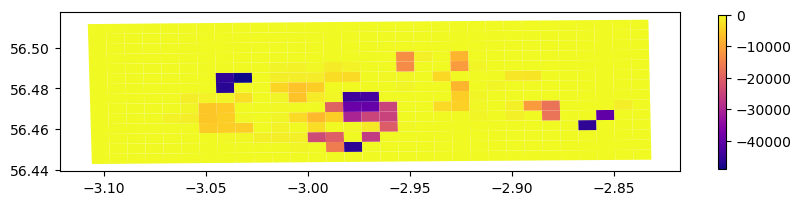

In [37]:
diff_df = pd.DataFrame(data = prob.getSolution(diff), index = Grids, columns=['diff'])

gdf.plot(column= diff_df["diff"],cmap = 'plasma',  legend=True,legend_kwds={'shrink': 0.5}, figsize=(10,4 ))

<AxesSubplot:>

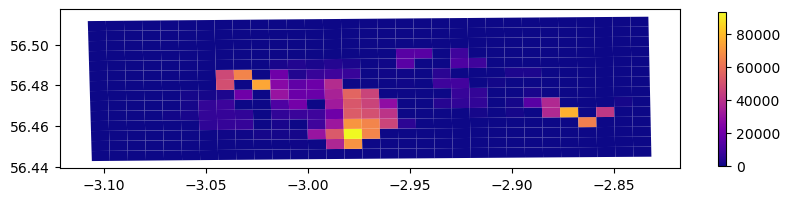

In [38]:
tsupply_df = pd.DataFrame(data = prob.getSolution(tsupply), index = Grids, columns=['tsupply'])

gdf.plot(column= tsupply_df["tsupply"],cmap = 'plasma', legend=True,legend_kwds={'shrink': 0.5}, figsize=(10,4 ))

<AxesSubplot:>

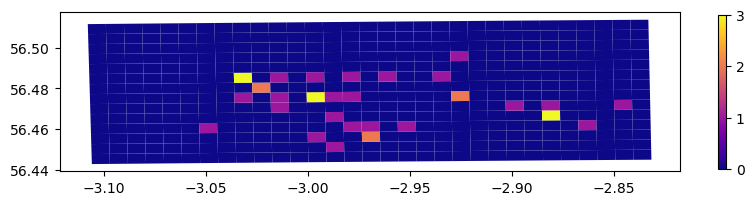

In [39]:
newpoint_df = pd.DataFrame(data = prob.getSolution(newpoint), index = Grids, columns=['newpoint'])
gdf.plot(column= newpoint_df["newpoint"],cmap = 'plasma', legend=True,legend_kwds={'shrink': 0.5}, figsize=(10,4 ))


<AxesSubplot:>

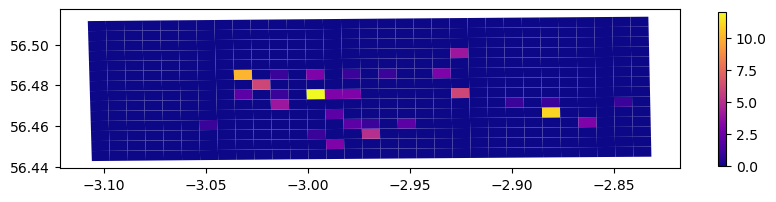

In [40]:
newstations_df = pd.DataFrame(data = prob.getSolution(newstations), index = Grids, columns=['newstations'])
gdf.plot(column= newstations_df["newstations"],cmap = 'plasma', legend=True,legend_kwds={'shrink': 0.5}, figsize=(10,4 ))

<AxesSubplot:>

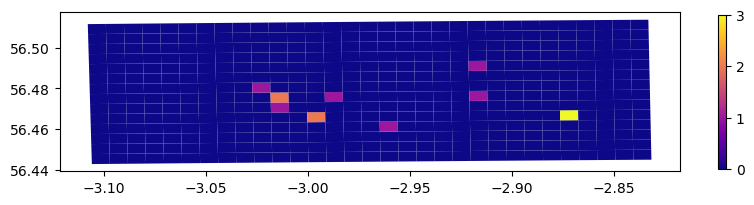

In [41]:
addstations_df = pd.DataFrame(data = prob.getSolution(addstations), index = Grids, columns=['addstations'])
gdf.plot(column= addstations_df["addstations"],cmap = 'plasma', legend=True,legend_kwds={'shrink': 0.5}, figsize=(10,4 ))

totstations_df = pd.DataFrame(data = (prob.getSolution(addstations)+prob.getSolution(newstations)) , index = Grids, columns=['totstations'])


#gdf.plot(column= totstations_df["totstations"],cmap = 'plasma', legend=True,legend_kwds={'shrink': 0.5}, figsize=(10,4 ))



for i in citycentre:
    numcen += newstations_df.iloc[i-1,0] + addstations_df.iloc[i-1,0] + init_points_pgrid[i-1]
    
numcen

curstations_df = pd.DataFrame(data = init_points_pgrid , index = Grids)
addstations_df = pd.DataFrame(data = prob.getSolution(addstations), index = Grids)
newstations_df = pd.DataFrame(data = prob.getSolution(newstations), index = Grids)

totstations_df = gdp.join(newstations_df, addstations_df, curstations_df)

In [50]:
#len((prob.getSolution(addstations).to_numpy() + prob.getSolution(newstations).to_numpy()))


a = np.array(prob.getSolution(addstations))
b = np.array(prob.getSolution(newstations))
c = np.array(init_points_pgrid)

len(a+b+c)

d = a+b+c 
print(np.where(d == 12))
print(np.where(d == 11))
print(np.where(d == 10))
print(np.where(d == 9))
print(np.where(d == 8))
print(np.where(d == 7))
print(np.where(d == 6))
print(np.where(d == 5))
print(sum(d))
print(sum(c))
print(sum(b))
print(sum(a))

(array([174], dtype=int64),)
(array([188, 354], dtype=int64),)
(array([120, 215], dtype=int64),)
(array([], dtype=int64),)
(array([133], dtype=int64),)
(array([], dtype=int64),)
(array([145, 213, 286], dtype=int64),)
(array([212, 368], dtype=int64),)
184.99999999999997
78
93.99999999999997
13.0


<AxesSubplot:>

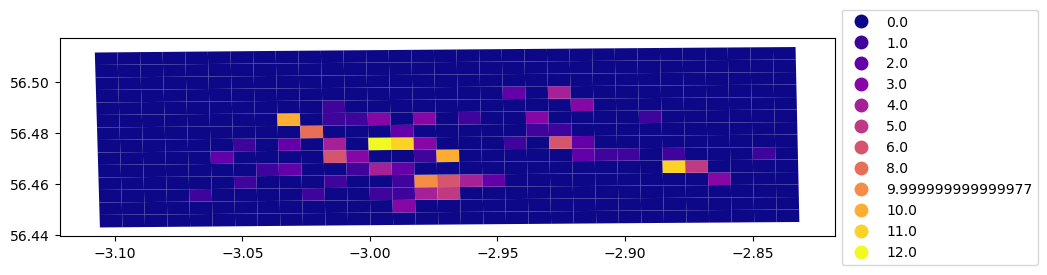

In [43]:
totstations2_df = pd.DataFrame(data = d , index = Grids, columns=['totstations'])

#totstations_df.loc[(totstations_df!=0).any(1) ]
#legend_kwds={'shrink': 0.5}, figsize=(10,4 )
#gdf.plot(column= totstations2_df["totstations"], cmap = 'plasma', legend=True , legend_kwds={'shrink': 0.5}, figsize=(10,4 ) )


#legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),  'fmt':"{:.0f}"}
#,  figsize=(10,4 )

gdf.plot(column= totstations2_df["totstations"] , categorical = True, cmap = 'plasma', legend=True ,
         legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5), "fmt": "{:.0f}"} ,  figsize=(10,5 ))